# Keras 

load datasets

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
hd_ttH=pandas.read_hdf('../../Files/skimmed/ttH.h5', 'df')
hd_ttW=pandas.read_hdf('../../Files/skimmed/ttW.h5', 'df')
hd_ttbar=pandas.read_hdf('../../Files/skimmed/ttbar.h5', 'df')

In [3]:
hd_ttH.keys()

Index(['DEtall01', 'lep_flavour', 'max_eta', 'minDeltaR_LJ_0',
       'minDeltaR_LJ_1', 'Meff', 'DRlj00', 'min_DRl0b', 'min_DRlj_new',
       'DPhij0MET', 'lead_BjetPt', 'lead_jet_sumBEff', 'sublead_jet_sumBEff',
       'scale_nom', 'pileupEventWeight_090', 'MV2c10_70_EventWeight',
       'JVT_EventWeight', 'SherpaNJetWeight', 'EventNumber', 'RunYear',
       'MET_RefFinal_et', 'lep_Pt_0', 'lep_Eta_0', 'lep_Phi_0', 'lep_Pt_1',
       'lep_Eta_1', 'lep_Phi_1', 'total_charge', 'Mll01', 'Ptll01', 'DRll01',
       'nJets_OR_T', 'nJets_OR_T_MV2c10_70', 'HT_lep', 'HT_jets', 'lead_jetPt',
       'sublead_jetPt', 'lepSFTrigTight', 'lepSFObjTight', 'weightS'],
      dtype='object')

In [4]:
variablelist_all_idx=hd_ttH.keys()
variablelist_all=variablelist_all_idx.tolist()

In [5]:
list_to_del=['scale_nom', 'pileupEventWeight_090', 'MV2c10_70_EventWeight',
           'JVT_EventWeight', 'SherpaNJetWeight', 'EventNumber', 'RunYear',
             'lepSFTrigTight', 'lepSFObjTight', 'weightS']

In [6]:
for i in list_to_del:
    variablelist_all.remove(i)

In [7]:
len(variablelist_all)/4

7.5

In [109]:
variablelist_all

['DEtall01',
 'lep_flavour',
 'max_eta',
 'minDeltaR_LJ_0',
 'minDeltaR_LJ_1',
 'Meff',
 'DRlj00',
 'min_DRl0b',
 'min_DRlj_new',
 'DPhij0MET',
 'lead_BjetPt',
 'lead_jet_sumBEff',
 'sublead_jet_sumBEff',
 'MET_RefFinal_et',
 'lep_Pt_0',
 'lep_Eta_0',
 'lep_Phi_0',
 'lep_Pt_1',
 'lep_Eta_1',
 'lep_Phi_1',
 'total_charge',
 'Mll01',
 'Ptll01',
 'DRll01',
 'nJets_OR_T',
 'nJets_OR_T_MV2c10_70',
 'HT_lep',
 'HT_jets',
 'lead_jetPt',
 'sublead_jetPt']

In [8]:
with open("../VarList_def.json") as vardict:
    variablelist = json.load(vardict)[:]
    
#variablelist

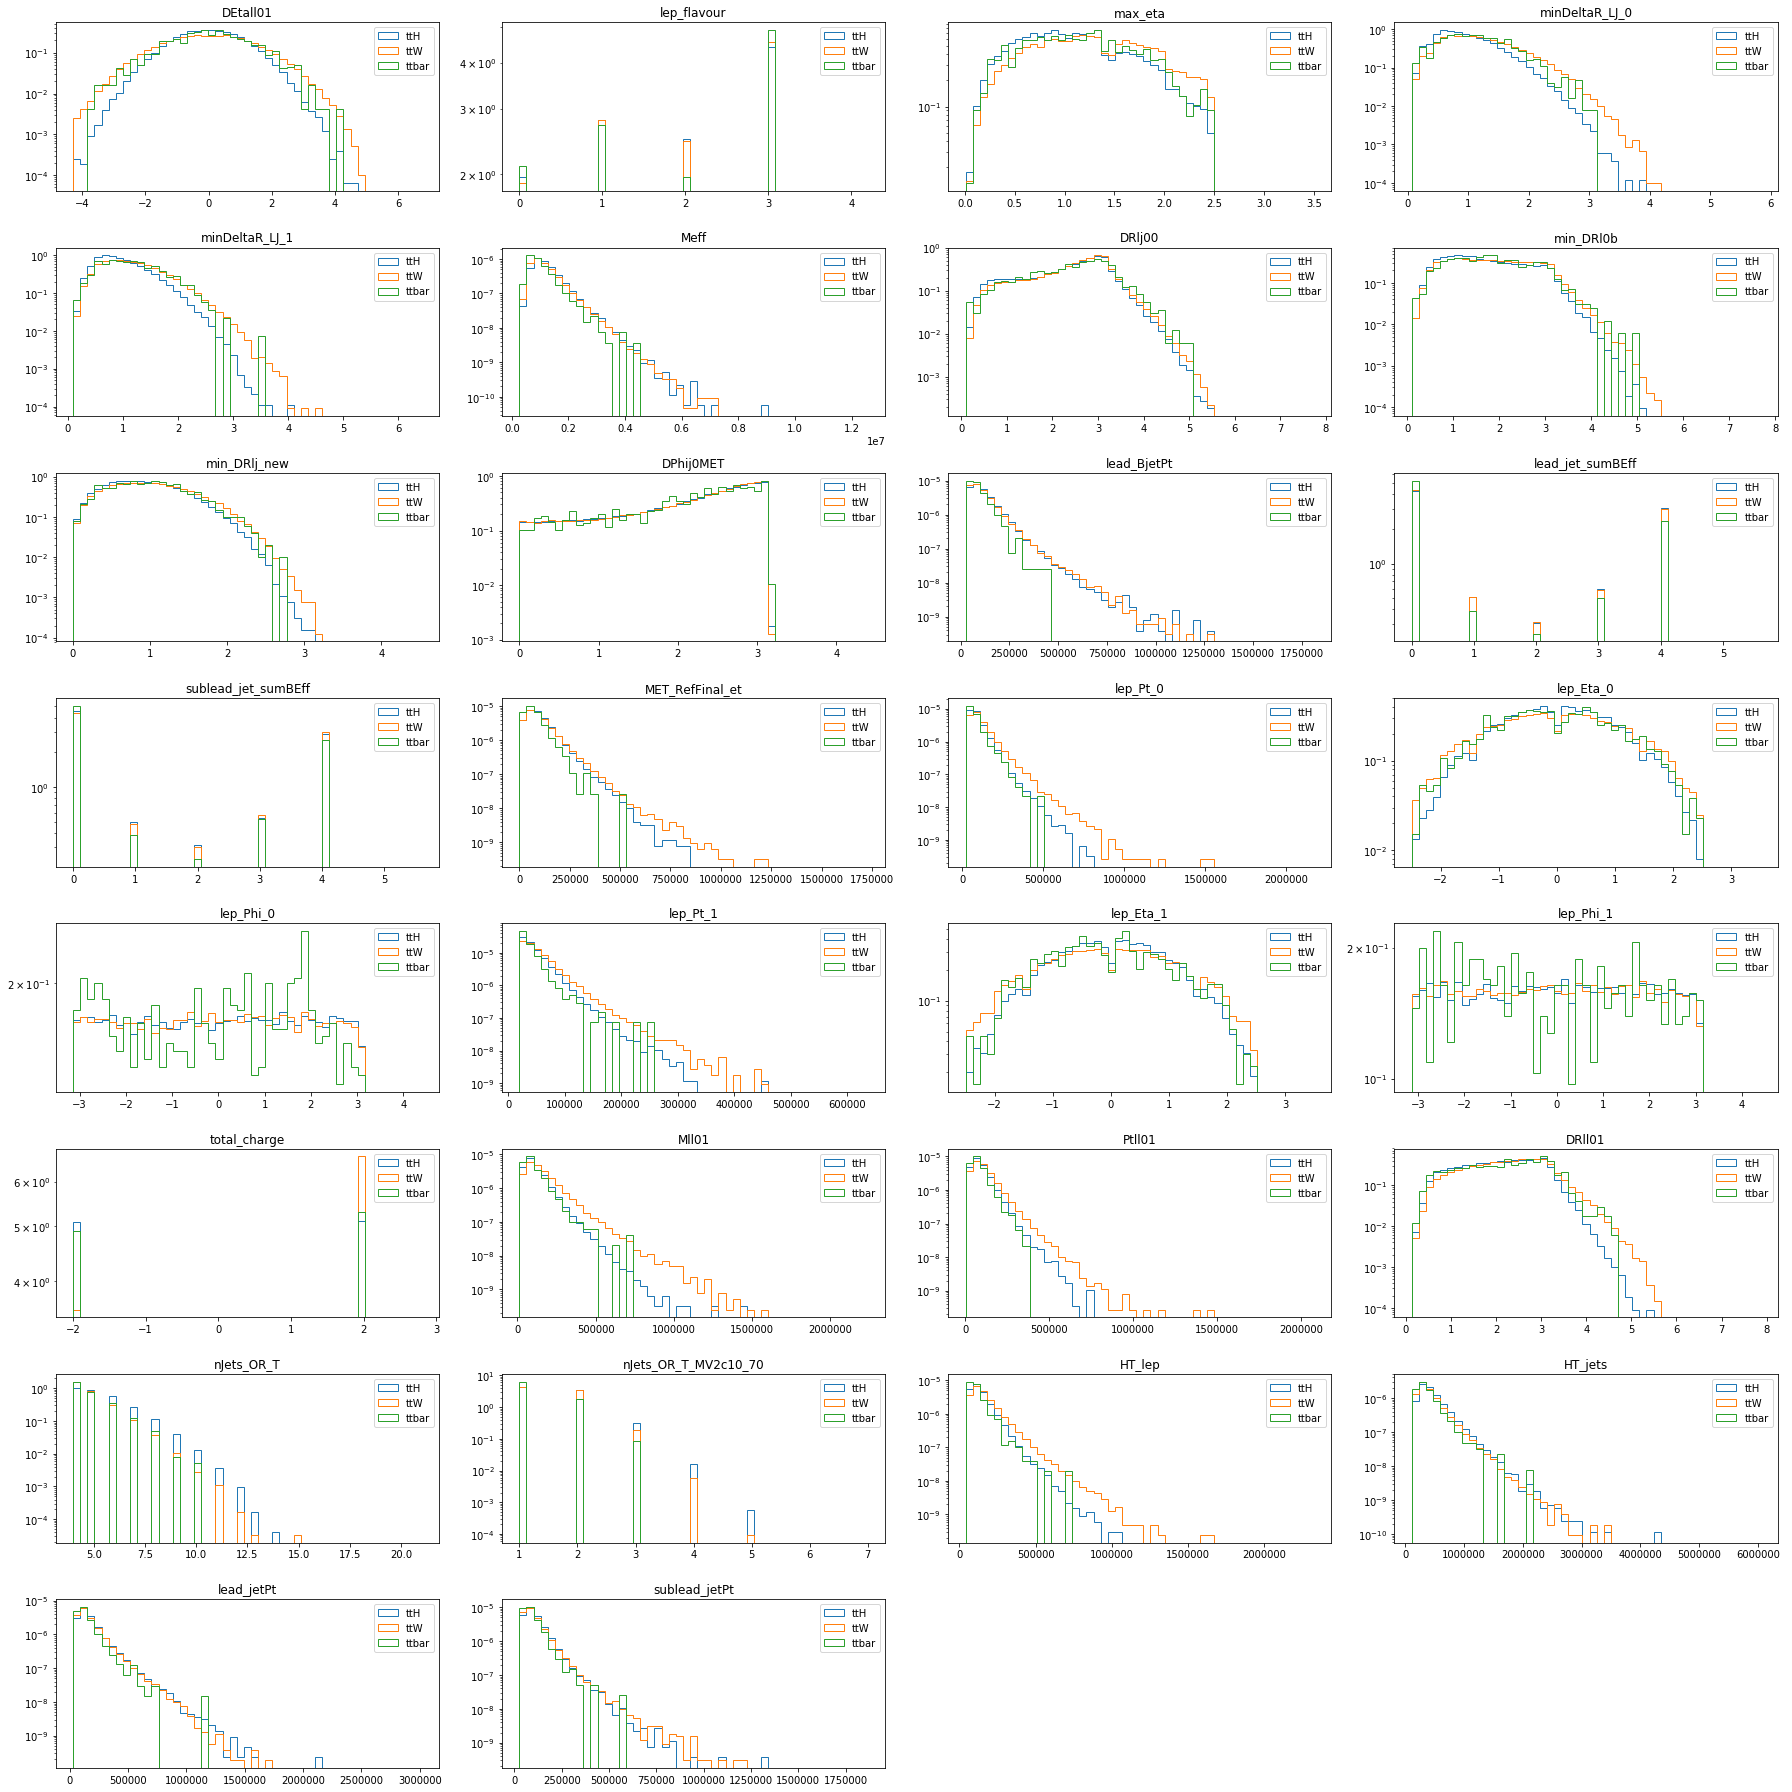

In [12]:
fig, ax = plt.subplots(8, 4, figsize=(25, 25))
nbins = 50
varlist=variablelist_all
varcounter = -1
for i, axobjlist in enumerate(ax):
      for j, axobj in enumerate(axobjlist):
        varcounter+=1
        if varcounter < len(varlist):
            var = varlist[varcounter]
            p_ttH = pandas.DataFrame({var: hd_ttH[var]})
            p_ttW = pandas.DataFrame({var: hd_ttW[var]})
            p_ttbar = pandas.DataFrame({var: hd_ttbar[var]})
           
            minval = np.amin(p_ttH[var])
            maxval = max([np.amax(p_ttH[var]), np.amax(p_ttW[var]), np.amax(p_ttbar[var])])*1.4
            binning = np.linspace(minval,maxval,nbins)

            axobj.hist(p_ttH[var],binning,histtype=u'step',label='ttH',density=1) # color='orange',
            axobj.hist(p_ttW[var],binning,histtype=u'step', label='ttW',density=1) 
            axobj.hist(p_ttbar[var],binning,histtype=u'step', label='ttbar',density=1) 
            axobj.legend()
            axobj.set_yscale('log',nonposy='clip')
            axobj.set_title(varlist[varcounter])

        else:
            axobj.axis('off')

plt.tight_layout()
plt.savefig("Plots/all_variables_3class.png", transparent=True)
plt.show()

build correlation matrix

In [19]:
ttH_vars=hd_ttH[variablelist_all]
ttW_vars=hd_ttW[variablelist_all]
ttbar_vars=hd_ttbar[variablelist_all]

## Two classes

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [23]:
# 
X = np.concatenate((ttH_vars,ttW_vars)) # training data   
sc = StandardScaler()
X = sc.fit_transform(X)
y = np.concatenate((np.ones(ttH_vars.shape[0]),np.zeros(ttW_vars.shape[0]))) # class lables                                                                                           



In [24]:
from sklearn.model_selection import train_test_split
seed=8
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [28]:
model = Sequential()
model.add(Dense(len(variablelist_all), input_dim=len(variablelist_all), activation='relu'))
model.add(Dropout(rate=0.1, noise_shape=None, seed=None))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [78]:
nEpochs = 20
bSize = 100

In [70]:
# Fit the model
nn_hist=model.fit(X_train, y_train, epochs=nEpochs, batch_size=bSize,validation_split=0.2) #, verbose=0

Train on 83967 samples, validate on 20992 samples
Epoch 1/20
83967/83967 [==============================] - 1s 14us/step - loss: 0.5386 - acc: 0.7257 - val_loss: 0.5512 - val_acc: 0.7171
Epoch 2/20
83967/83967 [==============================] - 1s 13us/step - loss: 0.5378 - acc: 0.7272 - val_loss: 0.5524 - val_acc: 0.7156
Epoch 3/20
83967/83967 [==============================] - 1s 13us/step - loss: 0.5386 - acc: 0.7257 - val_loss: 0.5535 - val_acc: 0.7149
Epoch 4/20
83967/83967 [==============================] - 1s 14us/step - loss: 0.5384 - acc: 0.7260 - val_loss: 0.5528 - val_acc: 0.7149
Epoch 5/20
83967/83967 [==============================] - 1s 14us/step - loss: 0.5382 - acc: 0.7257 - val_loss: 0.5532 - val_acc: 0.7155
Epoch 6/20
83967/83967 [==============================] - 1s 14us/step - loss: 0.5374 - acc: 0.7273 - val_loss: 0.5533 - val_acc: 0.7133
Epoch 7/20
83967/83967 [==============================] - 1s 14us/step - loss: 0.5381 - acc: 0.7266 - val_loss: 0.5530 - val_acc

In [71]:
#evaluate the trained model
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


acc: 71.32%


In [72]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


In [73]:

y_predicted = model.predict(X_test)
print (classification_report(y_test, y_predicted.round(), target_names=["signal", "background"]) )
print ("Area under ROC curve: %.4f"%(roc_auc_score(y_test, y_predicted)) )



              precision    recall  f1-score   support

      signal       0.72      0.79      0.75     28606
  background       0.70      0.62      0.66     23091

   micro avg       0.71      0.71      0.71     51697
   macro avg       0.71      0.70      0.71     51697
weighted avg       0.71      0.71      0.71     51697

Area under ROC curve: 0.7848


In [74]:
fpr, tpr, _ = roc_curve(y_test, y_predicted)

In [41]:
import xgboost
xgb_bdt = xgboost.XGBClassifier(tree_method="hist", thread_count=-1)
xgb_bdt.fit(X_train, y_train)
y_pred_xgb = xgb_bdt.predict(X_test)
xgb_bdt_ROC=roc_auc_score(y_test, xgb_bdt.predict_proba(X_test)[:, 1])
print("XGBoost ROC AUC = {:.3f}".format( xgb_bdt_ROC))


XGBoost ROC AUC = 0.762


In [48]:
fpr_bdt, tpr_bdt, _ = roc_curve(y_test, xgb_bdt.predict_proba(X_test)[:, 1])

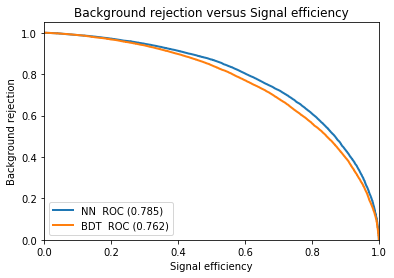

In [75]:
plt.figure()
lw = 2
plt.plot(tpr, 1-fpr, 
             lw=lw, label='%s ROC (%0.3f)' % ("NN ", roc_auc_score(y_test, y_predicted))) #color='darkorange',
plt.plot(tpr_bdt, 1-fpr_bdt, 
             lw=lw, label='%s ROC (%0.3f)' % ("BDT ", roc_auc_score(y_test, xgb_bdt.predict_proba(X_test)[:, 1]))) #color='darkorange',


#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#plt.plot(fpr, tpr, 
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic example')
###########
#plt.plot(tpr, 1-fpr, lw=3)
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
plt.title('Background rejection versus Signal efficiency')
plt.legend(loc="lower left")
#plt.yscale("log")
#plt.xlim(0.6,1)
#plt.ylim(0,1)
#plt.savefig("Plots/ROC_NN_BDT_tth_ttw.png", transparent=True)
plt.show()

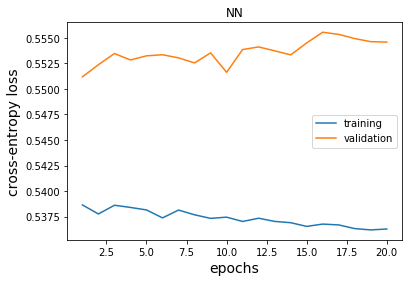

In [76]:
nn_hist.history
epochs = np.arange(1,len(nn_hist.history['loss'])+1)

plt.plot(epochs,nn_hist.history['loss'],label='training')
plt.plot(epochs,nn_hist.history['val_loss'],label='validation')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()
plt.title('NN')

plt.show()

In [80]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlyStop = EarlyStopping(monitor='val_loss', verbose=True, patience=10)
nn_mChkPt = ModelCheckpoint('nn_weights.h5',monitor='val_loss', verbose=True,
                              save_best_only=True,
                              save_weights_only=True)


In [83]:
nnErSt_hist = model.fit(X_train, y_train, epochs=nEpochs, batch_size=bSize,validation_split=0.4,
                     callbacks=[earlyStop, nn_mChkPt])

Train on 62975 samples, validate on 41984 samples
Epoch 1/20
62975/62975 [==============================] - 1s 16us/step - loss: 0.5337 - acc: 0.7290 - val_loss: 0.5415 - val_acc: 0.7244

Epoch 00001: val_loss improved from 0.55462 to 0.54152, saving model to nn_weights.h5
Epoch 2/20
62975/62975 [==============================] - 1s 15us/step - loss: 0.5318 - acc: 0.7299 - val_loss: 0.5441 - val_acc: 0.7214

Epoch 00002: val_loss did not improve from 0.54152
Epoch 3/20
62975/62975 [==============================] - 1s 15us/step - loss: 0.5331 - acc: 0.7295 - val_loss: 0.5426 - val_acc: 0.7228

Epoch 00003: val_loss did not improve from 0.54152
Epoch 4/20
62975/62975 [==============================] - 1s 15us/step - loss: 0.5327 - acc: 0.7307 - val_loss: 0.5443 - val_acc: 0.7211

Epoch 00004: val_loss did not improve from 0.54152
Epoch 5/20
62975/62975 [==============================] - 1s 16us/step - loss: 0.5317 - acc: 0.7290 - val_loss: 0.5455 - val_acc: 0.7198

Epoch 00005: val_loss

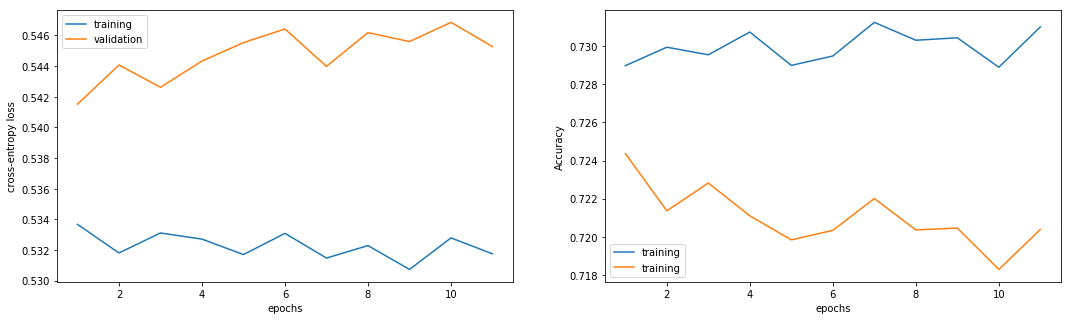

In [108]:
epochs = np.arange(1,len(nnErSt_hist.history['loss'])+1)

fig, ax = plt.subplots(1, 2, figsize=(18, 5))
#plt.set(fontsize=14)
ax[0].plot(epochs,nnErSt_hist.history['loss'],label='training')
ax[0].plot(epochs,nnErSt_hist.history['val_loss'],label='validation')
#plt.xlabel('epochs',fontsize=14)
ax[0].set(ylabel='cross-entropy loss')
ax[0].legend()
#ax[0].title('NN')
ax[1].plot(epochs,nnErSt_hist.history['acc'],label='training')
ax[1].plot(epochs,nnErSt_hist.history['val_acc'],label='training')
ax[1].legend()
ax[1].set(ylabel='Accuracy')
for axs in ax.flat:
    axs.set(xlabel='epochs')
plt.show()

In [85]:
y_predicted = model.predict(X_test)
print (classification_report(y_test, y_predicted.round(), target_names=["signal", "background"]) )
print ("Area under ROC curve: %.4f"%(roc_auc_score(y_test, y_predicted)) )

              precision    recall  f1-score   support

      signal       0.72      0.79      0.75     28606
  background       0.70      0.62      0.66     23091

   micro avg       0.71      0.71      0.71     51697
   macro avg       0.71      0.70      0.71     51697
weighted avg       0.71      0.71      0.71     51697

Area under ROC curve: 0.7827
